<a href="https://colab.research.google.com/github/pojo-25/drugProject/blob/branchProjectTrial0/ClasssicialModelToProjectDenemeTox21SR-ATAD5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd()) # add current working directory to pythonpath

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import pickle
import warnings
import argparse

In [2]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

In [3]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3837    0  3837    0     0  32794      0 --:--:-- --:--:-- --:--:-- 32516
100 20.2M  100 20.2M    0     0  4380k      0  0:00:04  0:00:04 --:--:-- 4278k


In [4]:
# move to python packages directory
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
x86 = '/usr/lib/x86_64-linux-gnu'

In [5]:
!mv lib/*.so.* $x86/

In [6]:
# rdkit need libboost_python3.so.1.65.1
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

In [7]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 


In [8]:
from sklearn.feature_selection import chi2
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, AllChem, ChemicalFeatures, Descriptors, Crippen, Lipinski
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem.Pharm2D.SigFactory import SigFactory


In [9]:
fdefName = '/content/models/MinimalFeatures.fdef'
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [10]:
def extract_properties(column, include_3D=False):
    """Extract various 1D descriptors
    https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors
    
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_properties: Pandas Series, containing 1D descriptors
    """

    def extract(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            if include_3D:
                return [0] * 29
            else:
                return [0] * 24
        else:
            logP = Crippen.MolLogP(mol)
            refractivity = Crippen.MolMR(mol)
            
            weight = Descriptors.MolWt(mol)
            exact_weight = Descriptors.ExactMolWt(mol)
            heavy_weight = Descriptors.HeavyAtomMolWt(mol)
            heavy_count = Lipinski.HeavyAtomCount(mol)
            nhoh_count = Lipinski.NHOHCount(mol)
            no_count = Lipinski.NOCount(mol)
            hacceptor_count = Lipinski.NumHAcceptors(mol)
            hdonor_count = Lipinski.NumHDonors(mol)
            hetero_count = Lipinski.NumHeteroatoms(mol)
            rotatable_bond_count = Lipinski.NumRotatableBonds(mol)
            valance_electron_count = Descriptors.NumValenceElectrons(mol)
            amide_bond_count = rdMolDescriptors.CalcNumAmideBonds(mol)
            aliphatic_ring_count = Lipinski.NumAliphaticRings(mol)
            aromatic_ring_count = Lipinski.NumAromaticRings(mol)
            saturated_ring_count = Lipinski.NumSaturatedRings(mol)
            aliphatic_cycle_count = Lipinski.NumAliphaticCarbocycles(mol)
            aliphaticHetero_cycle_count = Lipinski.NumAliphaticHeterocycles(mol)
            aromatic_cycle_count = Lipinski.NumAromaticCarbocycles(mol)
            aromaticHetero_cycle_count = Lipinski.NumAromaticHeterocycles(mol)
            saturated_cycle_count = Lipinski.NumSaturatedCarbocycles(mol)
            saturatedHetero_cycle_count = Lipinski.NumSaturatedHeterocycles(mol)
            
            tpsa = rdMolDescriptors.CalcTPSA(mol)
            
            if include_3D:
                mol_3D=Chem.AddHs(mol)
                AllChem.EmbedMolecule(mol_3D)
                AllChem.MMFFOptimizeMolecule(mol_3D)
                eccentricity = rdMolDescriptors.CalcEccentricity(mol_3D)
                asphericity = rdMolDescriptors.CalcAsphericity(mol_3D)
                spherocity = rdMolDescriptors.CalcSpherocityIndex(mol_3D)
                inertial = rdMolDescriptors.CalcInertialShapeFactor(mol_3D)
                gyration = rdMolDescriptors.CalcRadiusOfGyration(mol_3D)
            
                return [logP, refractivity, weight, exact_weight, heavy_weight, heavy_count, nhoh_count, no_count,
                        hacceptor_count, hdonor_count, hetero_count, rotatable_bond_count, valance_electron_count,
                        amide_bond_count, aliphatic_ring_count, aromatic_ring_count, saturated_ring_count,
                        aliphatic_cycle_count, aliphaticHetero_cycle_count, aromatic_cycle_count,
                        aromaticHetero_cycle_count, saturated_cycle_count, saturatedHetero_cycle_count, tpsa,
                        eccentricity, asphericity, spherocity, inertial, gyration]
            else:
                return [logP, refractivity, weight, exact_weight, heavy_weight, heavy_count, nhoh_count, no_count,
                        hacceptor_count, hdonor_count, hetero_count, rotatable_bond_count, valance_electron_count,
                        amide_bond_count, aliphatic_ring_count, aromatic_ring_count, saturated_ring_count,
                        aliphatic_cycle_count, aliphaticHetero_cycle_count, aromatic_cycle_count,
                        aromaticHetero_cycle_count, saturated_cycle_count, saturatedHetero_cycle_count, tpsa]
                
    feature_properties = column.apply(lambda x: extract(x))

    return np.array(list(feature_properties))

In [11]:
####################
## 2D descriptors ##
####################
def extract_MQNs(column, from_smiles=True):
    """Extract MQN features from smiles
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return feature_MQN: Pandas Series, containing 42 MQN feature
    """
    
    def get_MQNs(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*42
        else:
           return rdMolDescriptors.MQNs_(mol) 
       
    feature_MQN = column.apply(lambda x: get_MQNs(x, from_smiles))
    return np.array(list(feature_MQN))


def extract_Morganfp(column, radius=2, nBits=2048, useFeatures=False, from_smiles=True):
    """Extract Morganfingerprint
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param radius: int, indicates the radius in the Morgan fingerprint calculation.
    :param nBits: int, the number of bits in the resulting bit vector.
    :param useFeatures: bool, whether atoms' specific features are used
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_morgan: Pandas Series, containing Morganfingerprint features
    """
    
    def get_Morganfp(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*nBits
        else:
           return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useFeatures=useFeatures) 
        
    feature_morgan = column.apply(lambda x: get_Morganfp(x, from_smiles))
    return np.array(list(feature_morgan))


def extract_Pharm2D(column, minPointCount=2, maxPointCount=3, bins=[(0,2),(2,5),(5,8)], from_smiles=True):
    """Extract Pharm2D fingerprint
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param minPointCount: int
    :param maxPointCount: int
    :param bins: lits of tuples
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_Pharm2D: Pandas Series, containing Pharm2D features
    """
    sigFactory = SigFactory(featFactory,
                            minPointCount=minPointCount,
                            maxPointCount=maxPointCount,
                            trianglePruneBins=False)
    sigFactory.SetBins(bins)
    sigFactory.Init()
    
    def get_Pharm2D(x):
        mol = Chem.MolFromSmiles(x)
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*sigFactory.GetSigSize()
        else:
           return Generate.Gen2DFingerprint(mol, sigFactory)     

    fp = column.apply(lambda x: get_Pharm2D(x))
    return np.array(list(fp))


def extract_Gobbi_Pharm2D(column, from_smiles=True):
    """Extract Gobbi Pharm2D fingerprint
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_Gobbi Pharm2D: Pandas Series, containing Gobbi Pharm2D  features
    """
    
    def get_Gobbi_Pharm2D(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)
        
    feature_Gobbi = column.apply(lambda x: get_Gobbi_Pharm2D(x, from_smiles))
    return np.array(list(feature_Gobbi))


####################
## 3D descriptors ##
####################
def extract_RDF(column, from_smiles=True):
    """Extract RDF descriptor
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_RDF: Pandas Series, containing 210 RDF features
    """
    def get_RDF(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*210
        else:
            mol_3D=Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3D)
            AllChem.MMFFOptimizeMolecule(mol_3D)
            return rdMolDescriptors.CalcRDF(mol_3D) 
        
    feature_RDF = column.apply(lambda x: get_RDF(x, from_smiles))
    return np.array(list(feature_RDF))


def extract_AUTOCORR3D(column, from_smiles=True):
    """Extract AUTOCORR3D descriptor
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_AUTOCORR3D: Pandas Series, containing 80 AUTOCORR3D features
    """
    def get_AUTOCORR3D(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*80
        else:
            mol_3D=Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3D)
            AllChem.MMFFOptimizeMolecule(mol_3D)
            return rdMolDescriptors.CalcAUTOCORR3D(mol_3D) 
        
    feature_AUTOCORR3D = column.apply(lambda x: get_AUTOCORR3D(x, from_smiles))
    return np.array(list(feature_AUTOCORR3D)), np.arange(80)


def extract_MORSE(column, from_smiles=True):
    """Extract MORSE descriptor
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_MORSE: Pandas Series, containing 224 MORSE features
    """
    def get_MORSE(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*224
        else:
            mol_3D=Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3D)
            AllChem.MMFFOptimizeMolecule(mol_3D)
            return rdMolDescriptors.CalcMORSE(mol_3D) 
        
    feature = column.apply(lambda x: get_MORSE(x, from_smiles))
    return np.array(list(feature)), np.arange(224)


def extract_WHIM(column, from_smiles=True):
    """Extract WHIM descriptor
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_WHIM: Pandas Series, containing 114 WHIM features
    """
    def get_WHIM(x, from_smiles):
        if from_smiles:
            mol = Chem.MolFromSmiles(x)
        else:
            mol = x
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*114
        else:
            mol_3D=Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3D)
            AllChem.MMFFOptimizeMolecule(mol_3D)
            return rdMolDescriptors.CalcWHIM(mol_3D) 
        
    feature = column.apply(lambda x: get_WHIM(x, from_smiles))
    return np.array(list(feature)), np.arange(114)


def extract_GETAWAY(column, from_smiles=True):
    """Extract GETAWAY descriptor. GETAWAT descriptors have NaN values sometimes.
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param from_smiles: bool, indicate whether column contains smiles string
    :return: feature_GETAWAY: Pandas Series, containing 273 GETAWAY features
    """
    def get_GETAWAY(x):
        mol = Chem.MolFromSmiles(x)
        if (mol is None) or (len(mol.GetAtoms()) == 0):
            return [0]*273
        else:
            mol_3D=Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3D)
            AllChem.MMFFOptimizeMolecule(mol_3D)
            return rdMolDescriptors.CalcGETAWAY(mol_3D) 
        
    feature = column.apply(lambda x: get_GETAWAY(x))
    return np.array(list(feature)), np.arange(273)

In [12]:
def extract_features(column, method=['morgan'], from_smiles=True):
    """Extract 1D, 2D and 3D descriptors
    :param column: Pandas Series, containing smiles or RDKit mol object
    :param method: list, containing names of descriptors to extract
    :param from_smiles: bool, indicate whether column contains smiles string
    :return features: list of features extracted with method list
    """

    feature_list = []
    if 'morgan' in method:
        feature_list.append(extract_Morganfp(column))
    if 'mqn' in method:
        feature_list.append(extract_MQNs(column))
    if 'pharm2D' in method:
        feature_list.append(extract_Pharm2D(column))
    if 'gobbi' in method:
        feature_list.append(extract_Gobbi_Pharm2D(column))
    if 'physical' in method:
        feature_list.append(extract_properties(column, include_3D=False))
    if 'physical3D' in method:
        feature_list.append(extract_properties(column, include_3D=True))
    if 'autocorr3D' in method:
        feature_list.append(extract_AUTOCORR3D(column))
    if 'rdf' in method:
        feature_list.append(extract_RDF(column))
    if 'morse' in method:
        feature_list.append(extract_MORSE(column))
    if 'whim' in method:
        feature_list.append(extract_WHIM(column))
    if 'getaway' in method:
        feature_list.append(extract_GETAWAY(column))

    return np.concatenate(feature_list, axis=1)
        
     
def filter_feature_Chi2(feature_column, target_column, threshold=None):
    """Filter feature using Chi2 test
    :param: feature_column: numpy array containing feature
    :param: target_column: numpy array containing target variable
    :param: threshold: threshold to filter using Chi2.
                        threshold=None means all features with non Nan Chi2 pval will be returned.
    :return: feature_selected: features that are signficant
    :return: pval_significant: list of bool to indicate which features are significant
    """

    # Perform Chi2 test
    chi2_stats, pval = chi2(feature_column, target_column)

    # select only significant pvals
    pval_result = pval.copy()
    if threshold:
        pval_result[np.isnan(pval_result)] = 100  # replace Nan with any large value
        pval_significant = pval_result <= threshold
    else:
        pval_significant = np.logical_not(np.isnan(pval))

    # select features with significant pvals
    feature_selected = feature_column[:, pval_significant]

    return feature_selected, pval_significant

In [16]:
col_smiles = 'smiles'
col_target = 'SR-ATAD5'

METRIC_ACCURACY = 'accuracy'
METRIC_F1_SCORE = 'f1-score'
METRIC_COHEN_KAPPA = 'Cohen kappa'
METRIC_CONFUSION_MATRIX = 'Confusion Matrix'


CLASSES = ['benign', 'malignant']
TEST_RATIO = 0.2
SEED = 0

data_path = '/content/data/tox21.csv'

In [17]:
def read_data(data_path, col_smiles='smiles', col_target='SR-ATAD5'):
    """Split original data into train data and test data.
    :param data_path: str, path to the a CSV data file
    :param col_smiles: str, name of smiles column
    :param col_target: str, name of target column
    :param test_ratio: float, proportion of the original data for testset, must be from 0 to 1
    :param seed: int, randomization seed for reproducibility
    :return (X, y)
    """
    

    # read data
    df = pd.read_csv(data_path, sep=',')
    df_no_na = df[[col_smiles, col_target]].dropna()

    X = df_no_na[col_smiles]
    y = df_no_na[col_target].values

    # df['new_Bio'] = pd.factorize(df.bioactivity_class)[0]

    # df.head()

    # y = df['new_Bio'].values
    
    return X, y

                
def get_prediction_score(y_label, y_predict):
    """Evaluate predictions using different evaluation metrics.
    :param y_label: list, contains true label
    :param y_predict: list, contains predicted label
    :return scores: dict, evaluation metrics on the prediction
    """
    scores = {}
    scores[METRIC_ACCURACY] = accuracy_score(y_label, y_predict)
    scores[METRIC_F1_SCORE] = f1_score(y_label, y_predict, labels=None, average='macro', sample_weight=None)
    scores[METRIC_COHEN_KAPPA] = cohen_kappa_score(y_label, y_predict)
    scores[METRIC_CONFUSION_MATRIX] = confusion_matrix(y_label, y_predict)
    
    return scores

In [18]:
import os
import sys
sys.path.insert(0, os.getcwd()) # add current working directory to pythonpath

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import pickle
import warnings
import argparse

In [19]:
def train_model(model, X_train, y_train, parameters, n_splits=3):
    """Train model with Grid-search cross validation to find the best hyperparameter
    :param model: Scikit-learn estimator
    :param X_train: trainset features
    :param y_train: trainset label
    :param parameters: dict, key is hyper parameter name and value is a list of hyper parameter values
    :return best_estimator: Scikit-learn estimator with the best hyper parameter
    :return best_score: best accuracy score
    :return best_param: dict, best hyper parameter
    """
    
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(X=X_train, y=y_train)
    
    clf = GridSearchCV(model, parameters, cv=splits, scoring=make_scorer(accuracy_score))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # disable the warning on default optimizer
        clf.fit(X_train, y_train)
  

    return clf.best_estimator_, clf.best_score_, clf.best_params_


def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Evaluate model on testset
    :param model: Scikit-learn estimator
    :param X_train: trainset features
    :param y_train: trainset label
    :param X_test: testset features
    :param y_test: testset label
    :param parameters: dict, key is hyper parameter name and value is a list of hyper parameter values
    :return model: Scikit-learn estimator, fitted on the whole trainset
    :return y_predict: prediction on test set
    :return scores: dict, evaluation metrics on test set
    """
    
    # Refit the model on the whole train set
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # disable the warning on default optimizer
        model.fit(X_train, y_train)
        
    # Evaluate on test set
    y_predict = model.predict(X_test)
    scores = None
    if y_test is not None:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # disable the warning on f1-score with not all labels
            scores = get_prediction_score(y_test, y_predict)

    return model, y_predict, scores


def build_base_models(X_train, y_train):
    """Train and evaluate different base models. "Base" means the model is not a stacking model. 
    :param X_train: trainset features
    :param y_train: trainset label
    :return fitted_models: list, contains fitted Scikit-learn estimators
    :return model_names: list, names of fitted Scikit-learn estimators
    :return model_scores: list, contains scores on test set for fitted Scikit-learn estimators.
                    Each score is a dict of evaluation metrics
    """
    
    ########################
    # DEFINE BASE MODELS ###
    ########################
    models = []
    model_params = []
    model_names = []
    
    # Random forest model
    for n_estimators in [500, 1000, 2000]:
        for max_depth in [3, 5, 7]:
            models.append(RandomForestClassifier(max_features='sqrt', class_weight='balanced', random_state=0))
            model_params.append({'n_estimators':[n_estimators], 'max_depth':[max_depth]})
            model_names.append('Random Forest')   
    
    # Boosted Tree
    for n_estimators in [500, 1000, 2000]:
        for max_depth in [3, 5, 7]:
            for learning_rate in [0.01, 0.1]:
                models.append(GradientBoostingClassifier(subsample=0.7, max_features='sqrt', random_state=0))
                model_params.append({'n_estimators':[n_estimators], 'max_depth':[max_depth], 'learning_rate':[learning_rate]})
                model_names.append('Gradient Boosting Machine')
    
    # SVM
#    for kernel in ['linear', 'rbf']:
#        for C in [1.0, 10.0, 100.0, 1000.0]:
#            models.append(SVC(probability=True, gamma='auto', tol=0.001, cache_size=200, class_weight='balanced',
#                              random_state=0,
#                              decision_function_shape='ovr'))
#            model_params.append({'kernel':[kernel], 'C':[C]})
#            model_names.append('Support Vector Machine')
    
    # Logistic regression model
    for penalty in ['l1', 'l2']:
        for C in [1.0, 10.0, 100.0, 1000.0]:
            models.append(linear_model.LogisticRegression(max_iter=500, solver='liblinear', multi_class='ovr',
                                                          class_weight='balanced', random_state=0))
            model_params.append({'penalty':[penalty], 'C':[C]})
            model_names.append('Logistic Regression')
        
    # KNN
#    for n_neighbors in [5, 10, 15]:
#        for weights in ['uniform', 'distance']:
#            models.append(KNeighborsClassifier())
#            model_params.append({'n_neighbors':[n_neighbors], 'weights':[weights]})
#            model_names.append('K Nearest Neighbour')
            
    ##################################
    # TRAIN AND EVALUATE BASE MODELS #
    ##################################
    fitted_models = []
    model_scores = []
    for i in range(len(models)):
        print('Evaluating model {} of {}: {}'.format((i+1), len(models), model_names[i]))
        model = models[i]
        fitted_cv, _, _ = train_model(model=model, X_train=X_train, y_train=y_train, parameters=model_params[i])
        fitted_whole_set, _, score = evaluate_model(model=fitted_cv, X_train=X_train, y_train=y_train,
                                                    X_test=X_test, y_test=y_test)
        fitted_models.append(fitted_whole_set)
        model_scores.append(score)
        print(model_names[i], score)
        
    return fitted_models, model_names, model_scores


def build_stack_models(base_models, X_train, y_train):
    """Train and evaluate different stack models
    :param base_models: list, contains fitted base models, which are Scikit-learn estimators
    :param X_train: trainset features
    :param y_train: trainset label
    :return stack_fitted_models: list, contains fitted Scikit-learn estimators
    :return stack_model_names: list, names of fitted Scikit-learn estimators
    :return stack_model_scores: list, contains scores on test set for fitted Scikit-learn estimators.
                    Each score is a dict of evaluation metrics
    """
    
    ###############################
    ### PREPARE DATA FOR STACKING #
    ###############################
    print('Preparing data for model stacking')    
    # Get base models' prediction for test set: simply use the trained models to predict on test set
    X_test_stack = np.zeros([X_test.shape[0], len(base_models)])
    for i in range(len(base_models)):
        model = base_models[i]
        X_test_stack[:, i] = model.predict(X_test)
            
    # Get base models' prediction for train set: use 3-fold split, train model on 2 parts and predict on 3rd part
    splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(X=X_train, y=y_train)
    X_train_stack = np.zeros([X_train.shape[0], len(base_models)])
    for train_index, val_index in splits:
        # train and validation set
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, _ = y_train[train_index], y_train[val_index]

        # Fit model
        for i in range(len(base_models)):
            model = base_models[i]
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # disable the warning on default optimizer
                model.fit(X_tr, y_tr)
            X_train_stack[val_index, i] = model.predict(X_val)

    # Add base models' predictions into the feature space
    X_train_stack = np.concatenate([X_train, X_train_stack], axis=-1)
    X_test_stack = np.concatenate([X_test, X_test_stack], axis=-1)
          
    ########################
    # DEFINE STACK MODELS ##
    ########################
    stack_models = []
    stack_model_names = []
    stack_model_params = []
    
    stack_models.append(linear_model.LogisticRegression(max_iter=500, solver='liblinear', multi_class='ovr',
                                                        class_weight='balanced', random_state=0))
    stack_model_names.append('Stack Logistic Regression')
    stack_model_params.append({'penalty':['l1', 'l2'], 'C':[1.0, 10.0, 100.0, 1000.0]})
    
    stack_models.append(RandomForestClassifier(class_weight='balanced', random_state=0))
    stack_model_names.append('Stack Random Forest')
    stack_model_params.append({'n_estimators':[500, 1000, 2000], 'max_depth':[3, 5, 7]})
    
    stack_models.append(GradientBoostingClassifier(subsample=0.7, max_features='sqrt', learning_rate=0.01,
                                                   random_state=0))
    stack_model_names.append('Stack Gradient Boosting Machine')
    stack_model_params.append({'n_estimators':[500, 1000, 2000], 'max_depth':[3, 5, 7]})
    
#    stack_models.append(SVC(probability=True, gamma='auto', tol=0.001, cache_size=200, random_state=0,
#                             decision_function_shape='ovr', class_weight='balanced'))
#    stack_model_names.append('Stack Support Vector Machine')
#    stack_model_params.append({'kernel':['linear', 'rbf'], 'C':[1.0, 10.0, 100.0, 1000.0]})
    
#    stack_models.append(KNeighborsClassifier())
#    stack_model_names.append('Stack K Nearest Neighbour')
#    stack_model_params.append({'n_neighbors':[5, 10, 15], 'weights':['uniform', 'distance']})          

    #########################
    # EVALUATE STACK MODELS #
    #########################
    stack_fitted_models = []
    stack_model_scores = []
    for i in range(len(stack_models)):
        print('Evaluating model {} of {}: {}'.format((i+1), len(stack_models), stack_model_names[i]))
        model = stack_models[i]
        fitted_cv, _, _ = train_model(model=model, X_train=X_train_stack, y_train=y_train,
                                      parameters=stack_model_params[i])
        fitted_whole_set, _, score = evaluate_model(model=fitted_cv, X_train=X_train_stack, y_train=y_train,
                                                    X_test=X_test_stack, y_test=y_test)
        stack_fitted_models.append(fitted_whole_set)
        stack_model_scores.append(score)
        print(stack_model_names[i], score)
        
    return stack_fitted_models, stack_model_names, stack_model_scores
        

In [20]:
col_smiles = 'smiles'
col_target = 'SR-ATAD5'

METRIC_ACCURACY = 'accuracy'
METRIC_F1_SCORE = 'f1-score'
METRIC_COHEN_KAPPA = 'Cohen kappa'
METRIC_CONFUSION_MATRIX = 'Confusion Matrix'


CLASSES = ['benign', 'malignant']
TEST_RATIO = 0.2
SEED = 0

data_path = '/content/data/tox21.csv'

In [21]:
WORK_DIRECTORY = '/content/data'
DATA_FILE = 'tox21.csv'

data_path = os.path.join(WORK_DIRECTORY, DATA_FILE)
n_splits = 3
save_path = WORK_DIRECTORY


# Read data
X, y = read_data(data_path, col_smiles='smiles', col_target='SR-ATAD5')


In [ ]:
print(type(y))

<class 'numpy.ndarray'>


In [22]:
X_train = X.values
y_train_asArg = y


In [23]:
# Get train and test set
smiles_train, smiles_test, y_train, y_test = train_test_split(X_train, y_train_asArg, test_size = TEST_RATIO, shuffle=True, stratify=y, random_state=SEED)

In [ ]:
print(y_test)

[0 0 0 ... 0 0 0]


In [24]:
print(type(smiles_train))
print((X_train))

<class 'numpy.ndarray'>
['CCOc1ccc2nc(S(N)(=O)=O)sc2c1' 'CCN1C(=O)NC(c2ccccc2)C1=O'
 'CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C' ...
 'C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O'
 'C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@H]2O'
 'COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4']


In [25]:
df = pd.DataFrame(smiles_train, columns = ['Column_A'])

In [ ]:
print(type(df['Column_A']))

<class 'pandas.core.series.Series'>


In [26]:
# Extract features
feature_train = extract_features(df['Column_A'], method=['morgan', 'mqn'],
                                                    from_smiles=True)


In [27]:
df = pd.DataFrame(smiles_test, columns = ['Column_B'])

In [28]:
feature_test = extract_features(df['Column_B'], method=['morgan', 'mqn'],
                                                    from_smiles=True)

In [29]:
# Filter out irrelevant features
feature_train_filtered, pval_significant = filter_feature_Chi2(feature_train, y_train)
feature_test_filtered = feature_test[:, pval_significant]


In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(feature_train_filtered)
X_test = scaler.transform(feature_test_filtered)


In [31]:
# Build base models
base_models, base_model_names, base_model_scores = build_base_models(X_train, y_train)

if save_path is not None:
      # Save base models    
      os.makedirs(os.path.join(save_path, 'base_models'), exist_ok=True)
      for i in range(len(base_models)):
          with open(os.path.join(save_path, 'base_models', 'base_model_' + str(i+1) + '.pkl'), 'wb') as f:
              pickle.dump(base_models[i], f)
# Build level 1 stack models
stack_fitted_models, stack_model_names, stack_model_scores = build_stack_models(base_models.copy(),
                                                                                X_train, y_train)

if save_path is not None:
    # Save base models    
    os.makedirs(os.path.join(save_path, 'stacking_models'), exist_ok=True)
    for i in range(len(stack_fitted_models)):
        with open(os.path.join(save_path, 'stacking_models', stack_model_names[i] + '.pkl'), 'wb') as f:
            pickle.dump(stack_fitted_models[i], f)

            
# Summarize model performance
model_df = pd.DataFrame({'model': base_model_names + stack_model_names,
                          METRIC_ACCURACY: [score[METRIC_ACCURACY] for score in base_model_scores]\
                              + [score[METRIC_ACCURACY] for score in stack_model_scores],
                        METRIC_F1_SCORE: [score[METRIC_F1_SCORE] for score in base_model_scores]\
                              + [score[METRIC_F1_SCORE] for score in stack_model_scores],
                        METRIC_COHEN_KAPPA: [score[METRIC_COHEN_KAPPA] for score in\
                                                    base_model_scores]\
                              + [score[METRIC_COHEN_KAPPA] for score in stack_model_scores],
                        METRIC_CONFUSION_MATRIX: [score[METRIC_CONFUSION_MATRIX] for score in\
                                                          base_model_scores]\
                              + [score[METRIC_CONFUSION_MATRIX] for score in stack_model_scores]                            
                          })
model_df = model_df[['model', METRIC_ACCURACY, METRIC_F1_SCORE, METRIC_COHEN_KAPPA,
                      METRIC_CONFUSION_MATRIX]]
model_df.to_csv(os.path.join(WORK_DIRECTORY, 'summary_stacking_model.csv'), index=False)
model_df.sort_values(by=[METRIC_ACCURACY, METRIC_F1_SCORE, METRIC_COHEN_KAPPA],
                      ascending=False, inplace=True)
print('Best model:\n' + str(model_df.iloc[0]))



Evaluating model 1 of 35: Random Forest
Random Forest {'accuracy': 0.8070671378091873, 'f1-score': 0.5425478625707414, 'Cohen kappa': 0.14036126212533562, 'Confusion Matrix': array([[1109,  253],
       [  20,   33]])}
Evaluating model 2 of 35: Random Forest
Random Forest {'accuracy': 0.8614840989399293, 'f1-score': 0.5849446273570788, 'Cohen kappa': 0.1983419952711022, 'Confusion Matrix': array([[1187,  175],
       [  21,   32]])}
Evaluating model 3 of 35: Random Forest
Random Forest {'accuracy': 0.9060070671378092, 'f1-score': 0.6371801866585951, 'Cohen kappa': 0.2857630810919539, 'Confusion Matrix': array([[1250,  112],
       [  21,   32]])}
Evaluating model 4 of 35: Random Forest
Random Forest {'accuracy': 0.8056537102473498, 'f1-score': 0.5415311240425615, 'Cohen kappa': 0.1390792213050377, 'Confusion Matrix': array([[1107,  255],
       [  20,   33]])}
Evaluating model 5 of 35: Random Forest
Random Forest {'accuracy': 0.8699646643109541, 'f1-score': 0.5934009644936409, 'Cohen k

In [37]:
model_df.sort_values(by=[METRIC_ACCURACY, METRIC_F1_SCORE, METRIC_COHEN_KAPPA],
                      ascending=False, inplace=True)



In [39]:
model_df.style.background_gradient(cmap='coolwarm',axis=0)


,model,accuracy,f1-score,Cohen kappa,Confusion Matrix
18,Gradient Boosting Machine,0.970318,0.683573,0.371975,[[1360 2] [ 40 13]]
37,Stack Gradient Boosting Machine,0.969611,0.671323,0.348003,[[1360 2] [ 41 12]]
12,Gradient Boosting Machine,0.968905,0.648296,0.303533,[[1361 1] [ 43 10]]
23,Gradient Boosting Machine,0.968905,0.637213,0.282521,[[1362 0] [ 44 9]]
14,Gradient Boosting Machine,0.967491,0.643194,0.292592,[[1359 3] [ 43 10]]
26,Gradient Boosting Machine,0.967491,0.643194,0.292592,[[1359 3] [ 43 10]]
24,Gradient Boosting Machine,0.967491,0.632310,0.271875,[[1360 2] [ 44 9]]
25,Gradient Boosting Machine,0.966784,0.593214,0.197275,[[1362 0] [ 47 6]]
22,Gradient Boosting Machine,0.966078,0.627681,0.261835,[[1358 4] [ 44 9]]
20,Gradient Boosting Machine,0.966078,0.616323,0.240217,[[1359 3] [ 45 8]]


In [38]:
print(model_df)

                              model  ...         Confusion Matrix
18        Gradient Boosting Machine  ...    [[1360, 2], [40, 13]]
37  Stack Gradient Boosting Machine  ...    [[1360, 2], [41, 12]]
12        Gradient Boosting Machine  ...    [[1361, 1], [43, 10]]
23        Gradient Boosting Machine  ...     [[1362, 0], [44, 9]]
14        Gradient Boosting Machine  ...    [[1359, 3], [43, 10]]
26        Gradient Boosting Machine  ...    [[1359, 3], [43, 10]]
24        Gradient Boosting Machine  ...     [[1360, 2], [44, 9]]
25        Gradient Boosting Machine  ...     [[1362, 0], [47, 6]]
22        Gradient Boosting Machine  ...     [[1358, 4], [44, 9]]
20        Gradient Boosting Machine  ...     [[1359, 3], [45, 8]]
19        Gradient Boosting Machine  ...     [[1362, 0], [48, 5]]
10        Gradient Boosting Machine  ...     [[1359, 3], [46, 7]]
16        Gradient Boosting Machine  ...     [[1359, 3], [46, 7]]
15        Gradient Boosting Machine  ...     [[1362, 0], [50, 3]]
17        

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('ticks')

In [42]:
def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


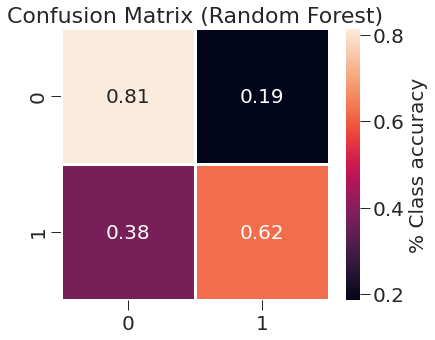

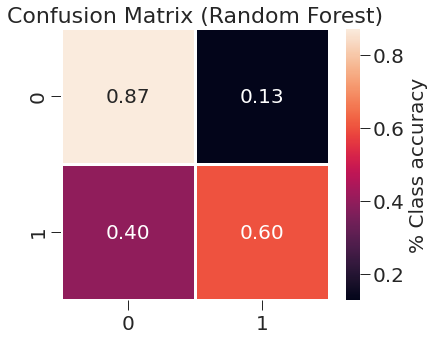

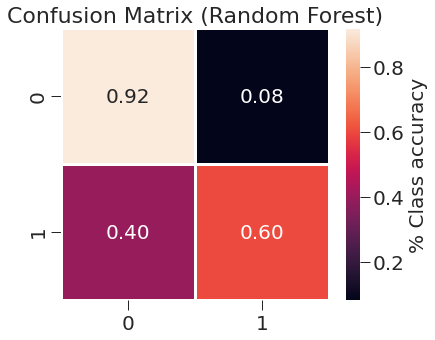

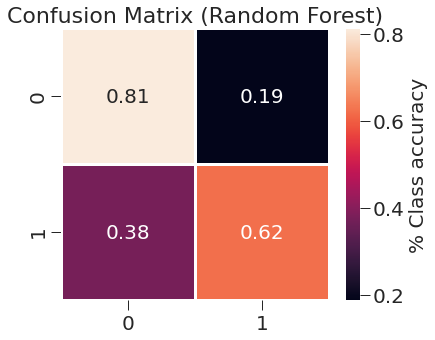

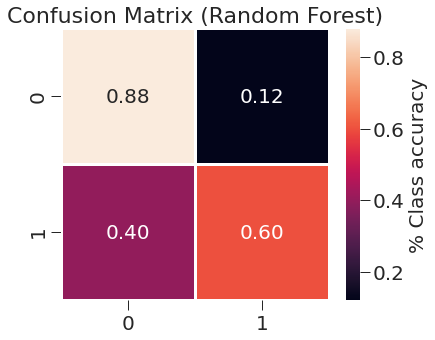

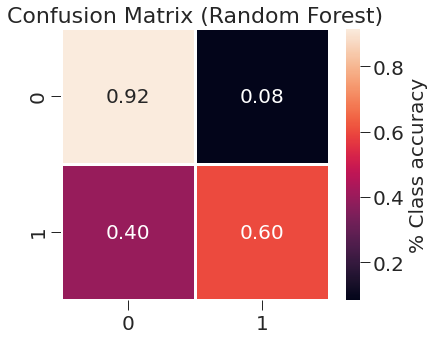

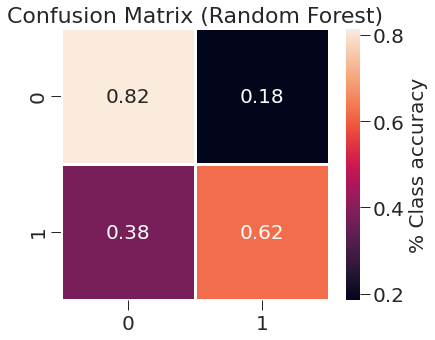

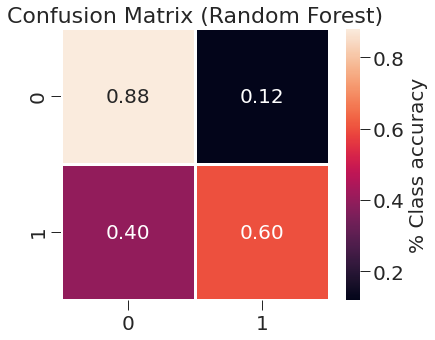

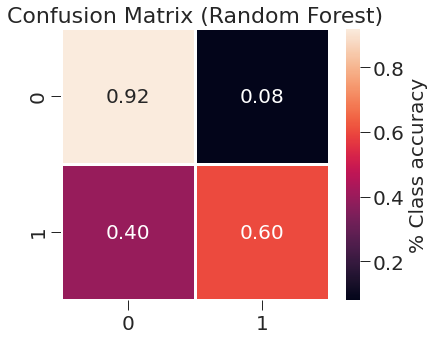

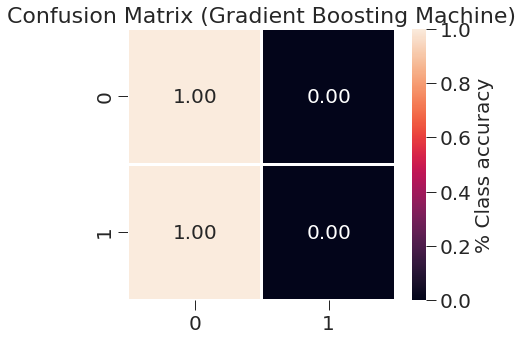

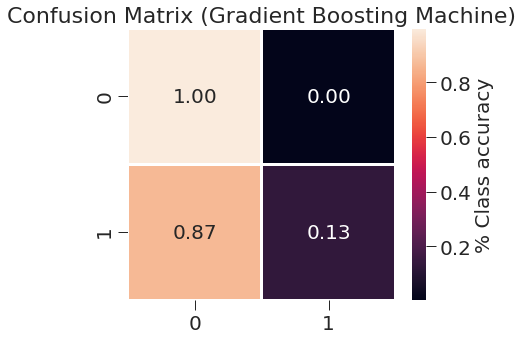

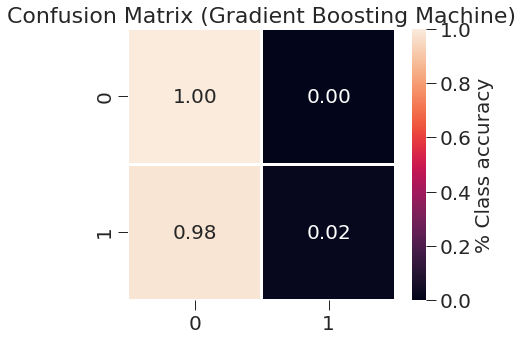

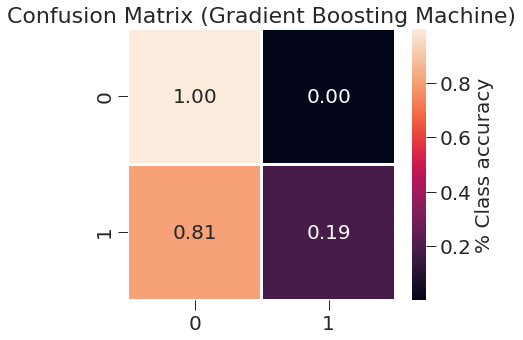

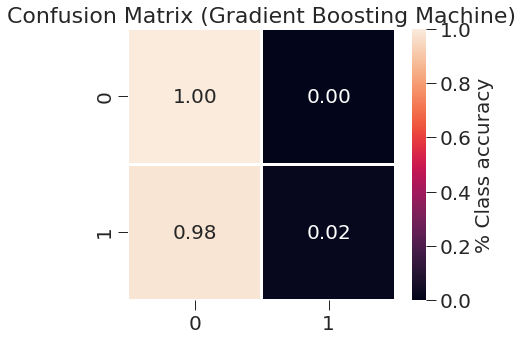

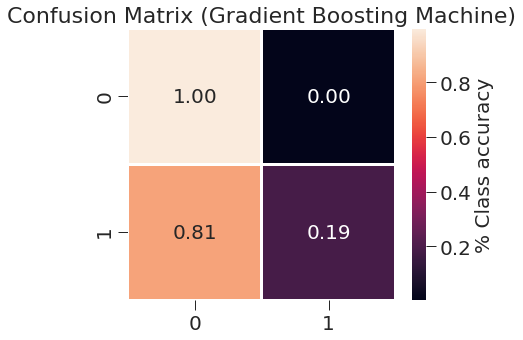

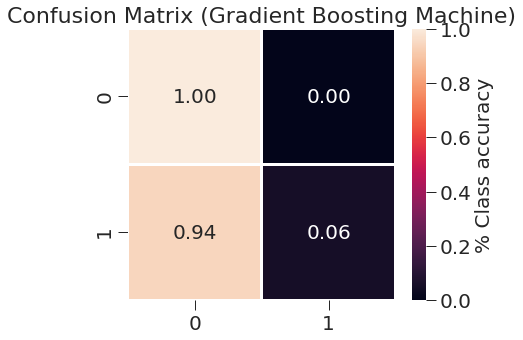

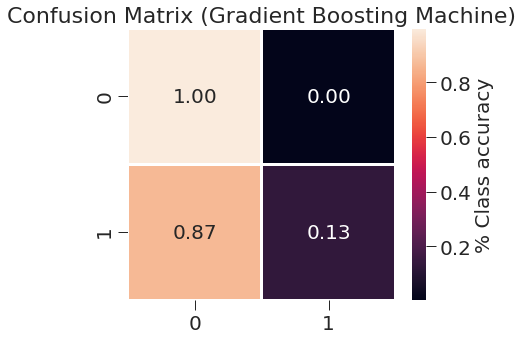

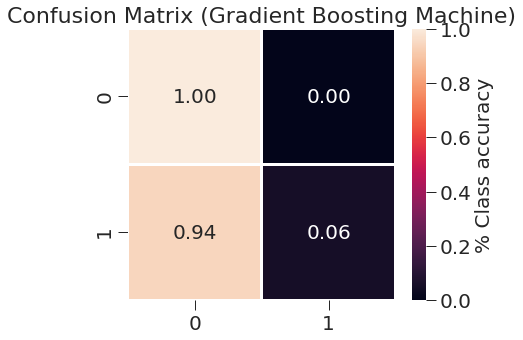

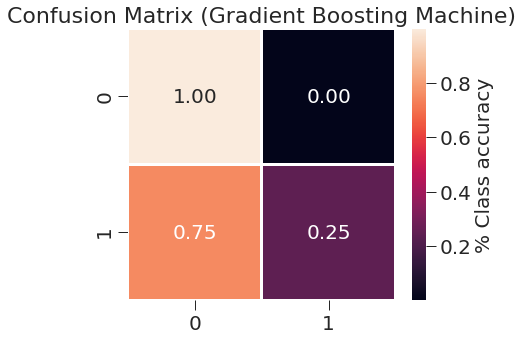

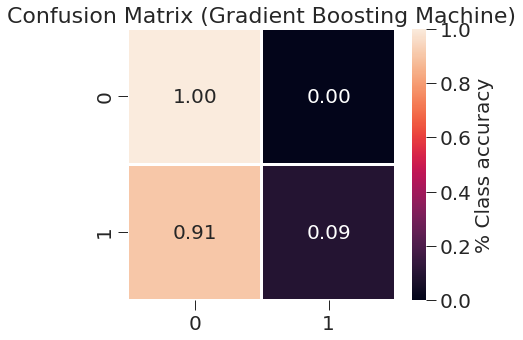

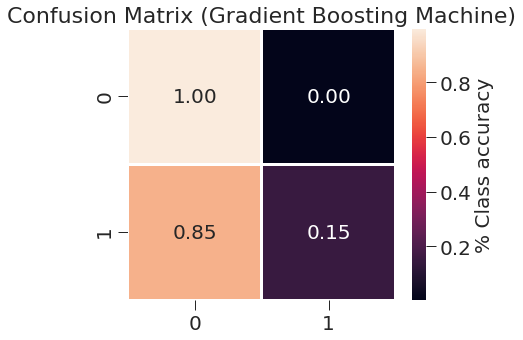

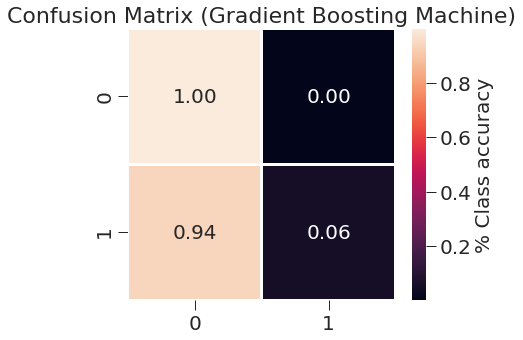

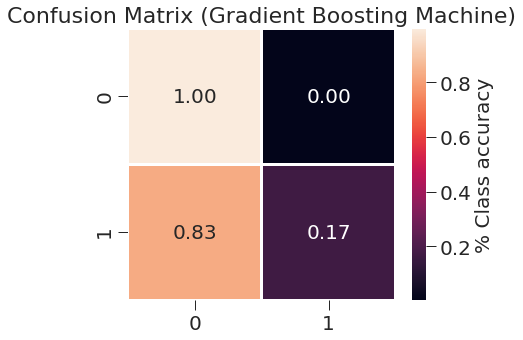

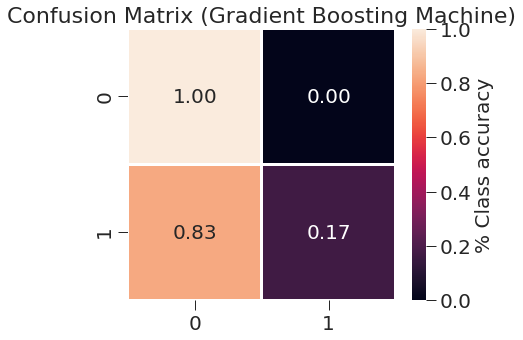

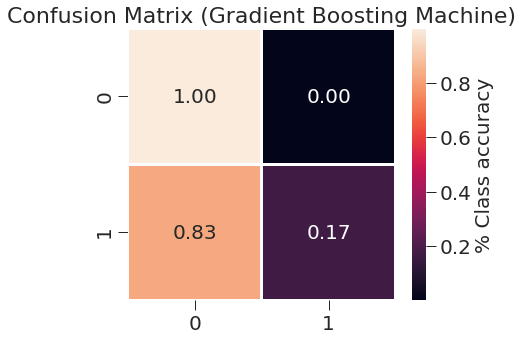

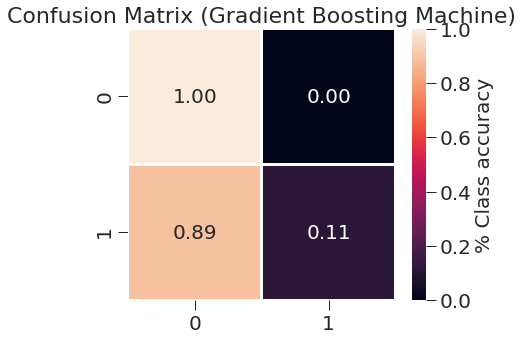

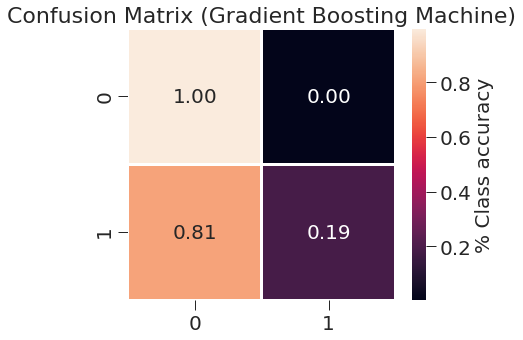

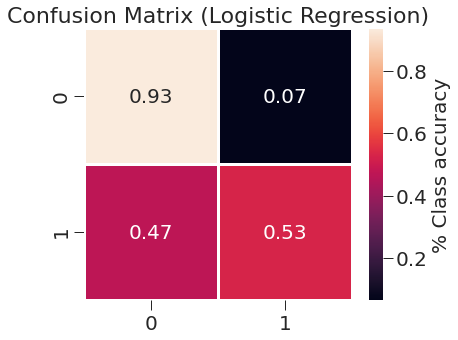

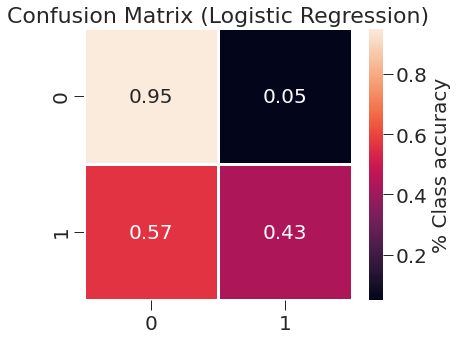

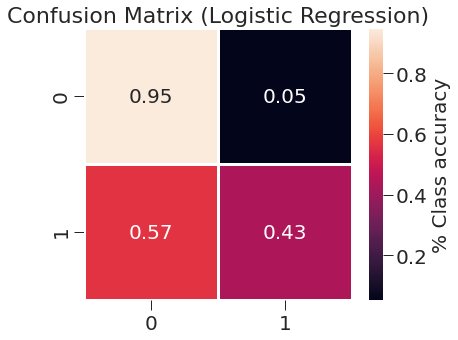

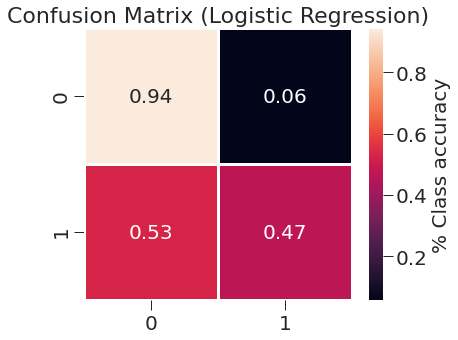

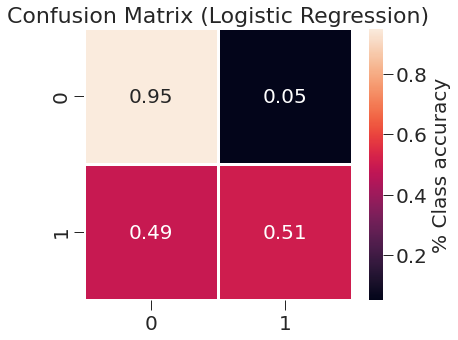

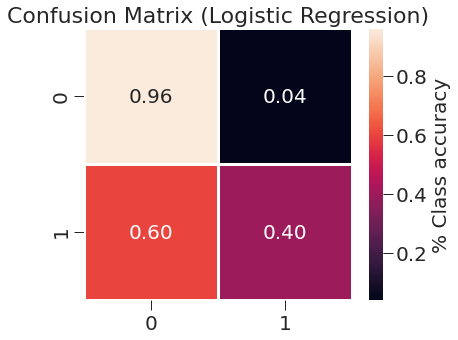

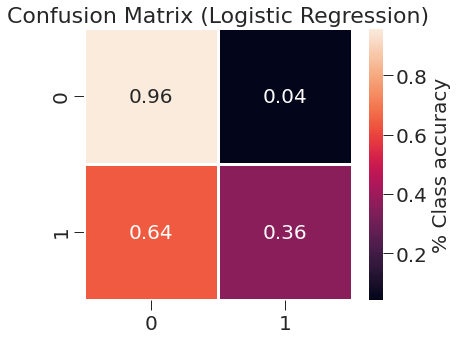

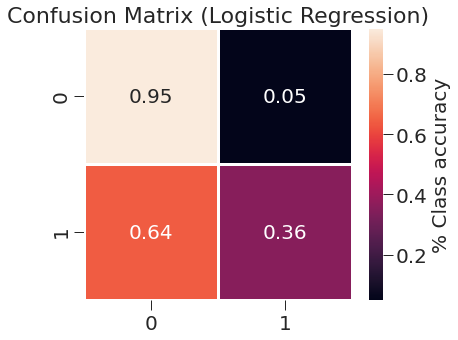

In [43]:

i = 0
for score in base_model_scores:
  conf_mat = score[METRIC_CONFUSION_MATRIX]
  normalized_confusion_matrix(y_test,conf_mat, base_model_names[i])
  i = i + 1

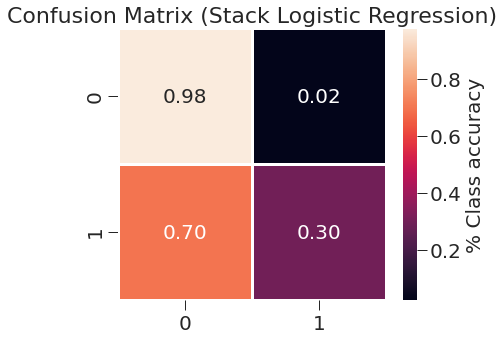

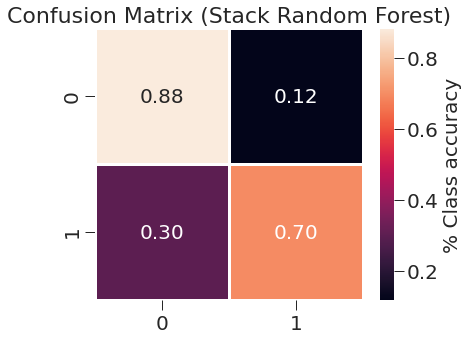

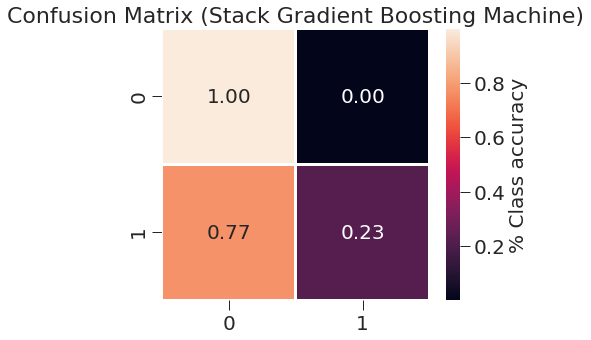

In [44]:
i = 0
for score in stack_model_scores:
  conf_mat = score[METRIC_CONFUSION_MATRIX]
  normalized_confusion_matrix(y_test,conf_mat, stack_model_names[i])
  i = i + 1

In [46]:
print(base_models[18])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


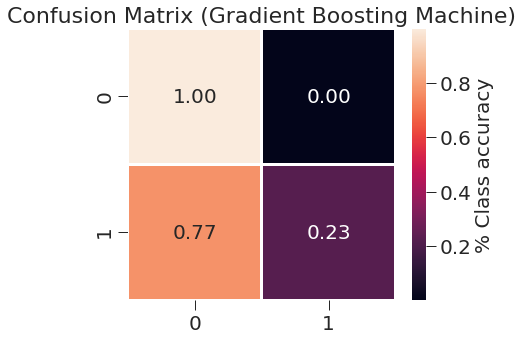

In [48]:
conf_mat = score[METRIC_CONFUSION_MATRIX]
normalized_confusion_matrix(y_test,conf_mat, base_model_names[18])

In [ ]:
# paramsGradient = {'n_estimators': 2000,
#           'max_depth': 7,
#           'learning_rate': 0.1}


modelGradient = GradientBoostingClassifier(subsample=0.7, max_features='sqrt', random_state=0, n_estimators=2000, max_depth=7, learning_rate=0.01 )

modelGradient.fit(X_train, y_train)


